# CompilerV0

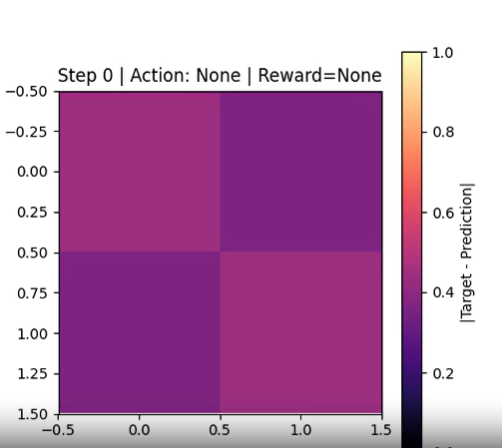

## Description

The **CompilerV0** environment is designed to simulate the task of **quantum gate compilation** for a single-qubit system.
It is based on the `QuantumEnv` base class. The agent's goal is to sequentially apply quantum gates to approximate a randomly chosen target **unitary operation**
from the special unitary group SU(2). This mimics a quantum compilation problem where one attempts to rewrite a quantum operation in terms of a limited gate set.

At each step, the agent applies one of several predefined single-qubit gates, evolving the current circuit unitary.
The agent receives a reward proportional to the **fidelity** between the evolved unitary and the target unitary, and the episode terminates when the agent either reaches a sufficiently high fidelity or exhausts the maximum step limit.

The environment includes a rendering mode that visualizes the **difference matrix** between the target and the current unitary as a heatmap evolving over time.

## Action Space

The action space is **discrete**, where each action corresponds to applying a quantum gate
from a fixed set of single-qubit operations:

| Num | Action    | Description                        |
|-----|-----------|------------------------------------|
| 0   | `H`       | Hadamard gate                      |
| 1   | `X`       | Pauli-X gate                       |
| 2   | `Y`       | Pauli-Y gate                       |
| 3   | `Z`       | Pauli-Z gate                       |
| 4   | `S`       | Phase gate                         |
| 5   | `SDG`     | Conjugate transpose of Phase gate  |
| 6   | `T`       | π/8 gate                           |
| 7   | `TDG`     | Conjugate transpose of π/8 gate    |
| 8   | `RX_pi_2` | X-axis rotation by π/2             |
| 9   | `RX_pi_4` | X-axis rotation by π/4             |
| 10  | `RY_pi_2` | Y-axis rotation by π/2             |
| 11  | `RY_pi_4` | Y-axis rotation by π/4             |
| 12  | `RZ_pi_2` | Z-axis rotation by π/2             |
| 13  | `RZ_pi_4` | Z-axis rotation by π/4             |

## Observation Space

The observation is a flattened representation of the current unitary matrix, expressed in terms
of its **real and imaginary parts**. This results in an 8-dimensional vector:

| Num | Observation Component | Range   |
|-----|------------------------|---------|
| 0-3 | Real part of unitary   | [-1, 1] |
| 4-7 | Imag part of unitary   | [-1, 1] |

This encodes the full \(2 \times 2\) complex unitary matrix.

## Rewards

The reward is based on the **average gate fidelity** between the target unitary  U_{target}
and the current unitary U. Specifically:

$reward = \frac{1}{2} \left| \mathrm{Tr}(U_{target}^\dagger U) \right|$

- A higher reward indicates closer alignment with the target unitary.
- The episode terminates early if the reward exceeds `reward_tolerance` (default: 0.98).

## Starting State

At the start of each episode:
- The circuit unitary is initialized as the **identity matrix** \( I \).
- The target unitary is specified by the user at initialization.  
(By default, this can be drawn from a random **U3(θ, φ, λ)** decomposition in SU(2).)

The initial observation corresponds to the identity matrix.


## Episode End

The episode ends if one of the following occurs:

1. **Termination**:  
The fidelity between the current and target unitary exceeds the reward tolerance (`reward > 0.98` by default).
2. **Truncation**:  
The number of steps exceeds the maximum episode length (`max_steps`, default: 30).


## Rendering

The environment supports visualization of the compilation process:

- A heatmap is drawn showing the **magnitude of the difference matrix**:
$|U_{target} - U|$
at each step.
- The heatmap updates dynamically, and the plot title displays the **step number, last applied gate, and reward**.

The animation can be saved as an MP4 file or displayed interactively.


## Arguments

- **`target`** (`np.ndarray`): The target \(2 \times 2\) unitary matrix to compile towards.  
- **`max_steps`** (`int`, default=30): Maximum number of steps per episode.  
- **`reward_tolerance`** (`float`, default=0.98): Fidelity threshold for early termination.
- **`ffmpeg`** (`bool`, default=False): If `True`, uses FFmpeg for saving animations; otherwise uses Pillow (GIF).


Initial Circuit State: [1. 0. 0. 1. 0. 0. 0. 0.]
After 12 action -> Observation: [ 6.123234e-17  0.000000e+00  0.000000e+00  6.123234e-17 -1.000000e+00
  0.000000e+00  0.000000e+00  1.000000e+00]
Reward: 0.6915053835406146 Done: False
After 8 action -> Observation: [ 3.7493994e-33  1.0000000e+00 -1.0000000e+00  3.7493994e-33
 -6.1232343e-17 -6.1232343e-17 -6.1232343e-17  6.1232343e-17]
Reward: 0.07040222778111221 Done: False
After 4 action -> Observation: [ 3.7493994e-33  1.0000000e+00  6.1232343e-17 -6.1232343e-17
 -6.1232343e-17 -6.1232343e-17 -1.0000000e+00  3.7493994e-33]
Reward: 0.45856820084368466 Done: False
After 10 action -> Observation: [-6.1232343e-17  1.2246469e-16  7.4987988e-33  1.0000000e+00
  1.0000000e+00 -7.4987988e-33 -1.2246469e-16 -6.1232343e-17]
Reward: 0.48548994973115384 Done: False
After 10 action -> Observation: [-1.1248198e-32 -1.0000000e+00 -6.1232343e-17  1.8369701e-16
  1.8369701e-16  6.1232343e-17  1.0000000e+00 -1.1248198e-32]
Reward: 0.45856820084368477

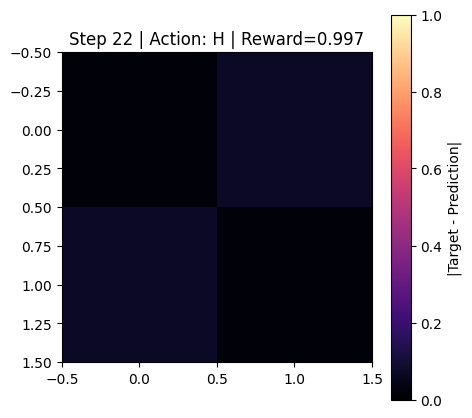

In [ ]:
## Example:


import numpy as np
from qrl.env.core.utils import RY, RZ
from qrl.env import CompilerV0

theta, phi, lam = np.random.uniform(0, 2*np.pi, 3)
target = (RZ(phi) @ RY(theta) @ RZ(lam))  # general SU(2)

# Initialize environment with 1 qubit
# set ffmpeg=True if you have ffmpeg installed to save as mp4, or ffmpeg=False to save as gif
env = CompilerV0(target_unitary=target, max_steps=30, reward_tolerance=0.98, ffmpeg=False)

# Reset
obs, _ = env.reset()
print("Initial Circuit State:", obs)

for _ in range(env.max_steps):
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    print(f"After {action} action -> Observation:", obs)
    print("Reward:", reward, "Done:", done)

    if done:
        break

# Render Bloch sphere
env.render(save_path_without_extension="compilerV0")